#Problema 13 de la guía 8
##S. Schiavinato LU:153/1
###Ajuste lineal y no lineal por cuadrados minimos, obteniendo los intervalos de confianza

In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as lin
import numpy.random as rnd
import scipy.misc as misc
import scipy.optimize as opt
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5 * (1 + np.sqrt(5)) / 2, 5)
plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 20

### Datos y gráfico de ellos

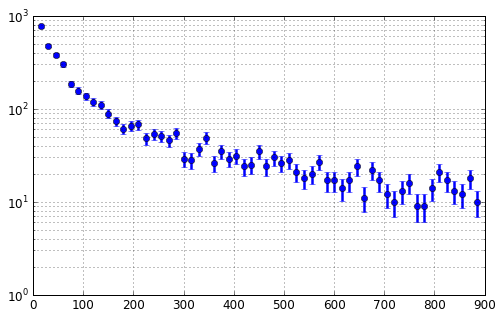

In [2]:
#Debe estar el archivo double_exp.dat en el mismo path que el ipynb
data = np.loadtxt("doble_exp.dat") 
x = data[:,0] #La primer columna son las absisas
y = data[:,1] #La segunda columna son las ordenadas
#Grafico los datos para probar que están bien importados
plt.yscale("log") #Escala logaritmica
plt.grid(which="both") #Grilla para ticks mayores y menores
#Grafico con errores poissoneanos
plt.errorbar(x, y, fmt='bo', yerr = np.sqrt(y));

### Caso lineal
El ajuste propuesto para estos datos corresponde a una doble exponencial

$y(t) = a_1 + a_2 \exp(-t / a_4) + a_3 \exp(-t / a_5)$

Si son conocidos $a_4$ y $a_5$, entonces es una ajuste lineal

$y(t) = a_1 f_1(t) + a_2 f_2(t) + a_3 f_3(t)$

que podemos escribirlo, considerando todos los datos, como

$\boldsymbol{y} = \mathbb{A} \boldsymbol{\theta}$  

donde

$A_{i *} = \begin{pmatrix} f_1(t_i) & f_2(t_i) & f_3(t_i) \end{pmatrix} = \begin{pmatrix} 1 & \exp(-t_i/a_4) & \exp(-t_i/a_5) \end{pmatrix}$  

$\boldsymbol{\theta} = \begin{pmatrix} a_1 \\ a_2 \\ a_3 \end{pmatrix}$

Ahora la implementación del ajuste lineal corresponde a minimizar

$\chi^2 = (\vec{y} - \mathbb{A} \boldsymbol{\theta})^T V^{-1} (\vec{y} - \mathbb{A} \boldsymbol{\theta})$

con $\mathbb{V} = \text{Cov}(y_i, y_j)$, que tiene como solución

$ \hat{\boldsymbol{\theta}} = (\mathbb{A}^T V^{-1} \mathbb{A})^{-1} \mathbb{A}^T V^{-1} \vec{y}$  
$\mathbb{V}(\boldsymbol{\theta}) = \text{Cov}(\theta_i, \theta_j) = (\mathbb{A}^T V^{-1} \mathbb{A})^{-1}$

Esto se implementa a continuación, con los valores conocidos de los parámetros $a_4$ y $a_5$ 

θ = [  10.68876993  127.93980303  960.86543921] 

 Cov(θ) = [[  0.16378467  -0.59346038   0.93675028]
 [ -0.59346038   4.91456416 -10.11657616]
 [  0.93675028 -10.11657616  55.05384207]]


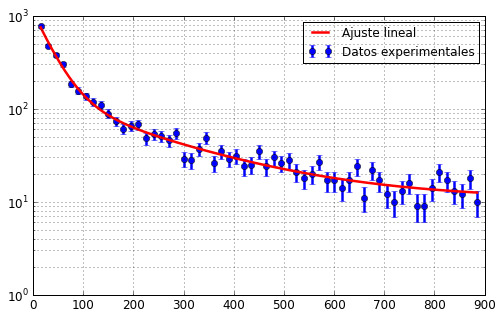

In [3]:
a4, a5 = 209.69, 34.244 #Los parámetros conocidos
fMat = lambda t : (1, np.exp(-i/a4), np.exp(-i/a5)) #Defino la matriz A
#La inversa de una matriz diagonal es la diagonal con todas las inversas
Vinv = np.diag(1/np.sqrt(y)) #Matriz covarianza inversa de y
A = []
for i in np.nditer(x):
    A.append(fMat(i))
A = np.array(A)
Vθ = lin.inv(A.T.dot(Vinv).dot(A))
θ = Vθ.dot(A.T.dot(Vinv).dot(y))
print("θ = {} \n\n Cov(θ) = {}".format(θ, Vθ))

#Interpolo con los parámetros de cuadrados minimos lineal
t = np.linspace(x.min(), x.max(), 1e5)
A = []
for i in np.nditer(t): #Itero en t
    A.append(fMat(i))
A = np.array(A)

#Configuraciones de la figura
plt.figure(1)
plt.yscale("log")
plt.grid(which="both")

plt.errorbar(x, y, fmt='bo', yerr = np.sqrt(y), label = "Datos experimentales") #Datos, con errores poissoneanos
plt.plot(t, A.dot(θ), 'r-', label = "Ajuste lineal") #Ajuste
plt.legend(loc = 0);

Para completar se grafican curvas de nivel de la función $\chi^2 - \chi^2_{\min}$ (para los parámetros $a_1$, $a_2$ y $a_3$ en conjuntos de dos), que corresponden a elipses concentricas. En particular se consideran los niveles $2.3$, $6$ que corresponde a una probabilidad de $68\%$ y $95\%$.

95%CL
I(a3) = [952.43, 969.30]
I(a2) = [124.75, 131.13]
I(a1) = [10.20, 11.17]
68%CL
I(a3) = [947.24, 974.49]
I(a2) = [122.78, 133.10]
I(a1) = [9.91, 11.47]


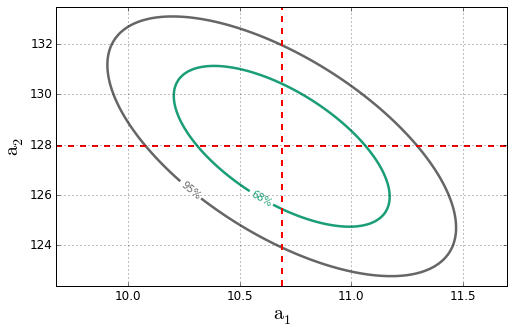

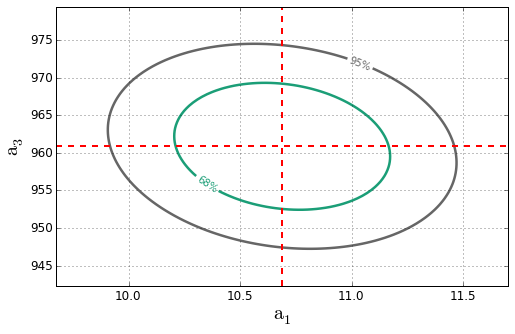

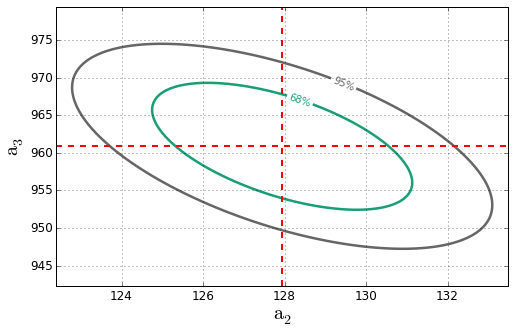

In [4]:
f = lambda t, p : p[0] + p[1] * np.exp(-t/209.69) + p[2] * np.exp(-t/34.244)
#Funcion objetivo, que ya se minimizó para cuadrados minimos
S = lambda p: np.sum((y - f(x,p))**2/y)
N = 100
#En la variable intervals guardo los intervalos de confianza
intervals = {"68%": {'a1': [], 'a2': [], 'a3': []}, "95%": {'a1': [], 'a2': [], 'a3': []}}
for i in range(3):
    for j in range(i+1,3):
        #Rango de valores
        a = np.linspace(θ[i] - 2.5 * np.sqrt(Vθ[i,i]), θ[i]  +  2.5 * np.sqrt(Vθ[i,i]), N)
        b = np.linspace(θ[j] - 2.5 * np.sqrt(Vθ[j,j]), θ[j]  + 2.5 * np.sqrt(Vθ[j,j]), N)
        
        #Genero los valores las funciones X - Xmin para cada par de parámetros
        X = []
        for k in a:
            for l in b:
                #Creo el vector θh, que es la variable
                #θ es el estimador de cuadrados minimos
                θh = θ.tolist()
                θh[i] = k
                θh[j] = l
                θh = np.array(θh)
                #La definición de χ2 - χ2min es la siguiente
                X.append((θh - θ).T.dot(np.linalg.inv(Vθ)).dot(θh - θ))
        X = np.reshape(np.array(X), (N,N))
        
        #Figura 2, configuración
        plt.figure()
        plt.grid(which = "both")

        #Grafico las curvas de nivel de X, junto con los labels de cada nivel
        plt.xlabel(r"$\mathrm{{a}}_{}$".format(i+1))
        plt.ylabel(r"$\mathrm{{a}}_{}$".format(j + 1))

        #Agrego dos líneas punteadas, una horizontal y otra vertical
        #Corresponde a los valores a4, a5 de cuadrados mínimos
        plt.axvline(θ[i], ls = "--", lw = 2, c = "r")
        plt.axhline(θ[j], ls = "--", lw = 2, c = "r")

        #Ahora grafico las curvas de nivel, para el nivel 1 (39%)
        #plt.contour(a, a, X, levels = (1, 4, 9), colors = ["b"])
        plt.set_cmap("Dark2")
        cs = plt.contour(a, b, X, levels = (2.3, 6));
        plt.clabel(cs, fmt = {2.3:"68%", 6: "95%"})
        
        #Genero los intervalos de confianza
        #cs es una variable que contiene los contornos.
        #Necesito guardarme el máximo y el minimo en cada dimensión
        #que me da el intervalo de confianza para cada variable
        #Lo guardo en un diccionario armado para después imprimirlo
        CL = ["95%", "68%"]
        for n, c in enumerate(cs.allsegs):
            if (i == 0 and j == 1):
                intervals[CL[n]]["a1"] = [c[0][:,0].min(), c[0][:,0].max()]
            if (i == 0 and j == 2):
                intervals[CL[n]]["a3"] = [c[0][:,1].min(), c[0][:,1].max()]
            if (i == 1 and j == 2):
                intervals[CL[n]]["a2"] = [c[0][:,0].min(), c[0][:,0].max()]
#Imprimo el diccionario
for cl in intervals.keys():
    print("{}CL".format(cl))
    for param in intervals[cl].keys():
        print("I({}) = [{:.2f}, {:.2f}]".format(param, intervals[cl][param][0],  intervals[cl][param][1]))

#### Caso no lineal

####Se pide a continuación, efectuar el minimizado no lineal, es decir con $a_4$ y $a_5$ libres.
Nota: volvemos a reutilizar las nombres de variables

θ = [  10.13406013  128.28050165  957.76956988  209.69162492   34.24437634]
Cov(θ):
[  3.60671284  28.46132621  -3.51647265 -53.33568629  -2.42668161]
[  28.46132621  449.02624603   82.63546485 -626.91492383  -43.09410164]
[   -3.51647265    82.63546485  2452.11377844    -8.76683527   -68.8224133 ]
[  -53.33568629  -626.91492383    -8.76683527  1009.23780478    55.83315073]
[ -2.42668161 -43.09410164 -68.8224133   55.83315073   6.35410237]


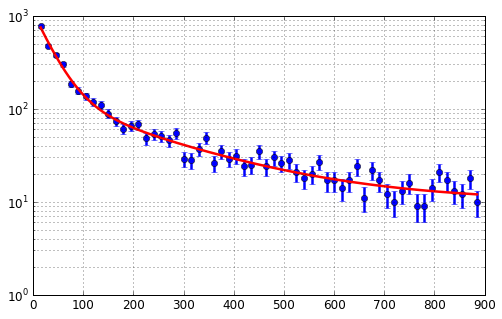

In [5]:
#Redefino la función a minimizar
f = lambda t, p : p[0] + p[1] * np.exp(-t/p[3]) + p[2] * np.exp(-t/p[4])
#Funcion objetivo a minimizar
err = lambda p: (y - f(x, p))/np.sqrt(y)
S = lambda p: np.sum((y - f(x,p))**2/y)
#Minimizo en la siguiente línea, con la librería scipy.optimize
r, cov, infodic, mes, ier = opt.leastsq(err, (10, 130, 900, 200, 35), full_output = 1)
#print(r)
#res = opt.minimize(S, x0 = (10, 130, 900, 200, 35)) 
θ = r
print("θ = {}".format(θ))
print("Cov(θ):")
for i in range(cov.shape[0]):
    print("{}".format(cov[i,:]))

#Figura 1, configuración
plt.figure(1)
plt.grid(which = "both")
plt.yscale("log")

#Grafico los datos
plt.errorbar(x, y, fmt='bo', yerr = np.sqrt(y))

#Graficación del ajuste
t = np.linspace(x.min(), x.max(), 1e5)
plt.plot(t, f(t,θ) , 'r-');

Ahora se buscan las regiones de confianza, pero solamente para $a_4$ y $a_5$. Para ello, los demás parámetros ($a_1$, $a_2$ y $a_3$) se buscan tal que minimizen la función objetivo para cada par ($a_4$, $a_5$). Esto asegura que las curvas de nivel solo dependan de los parámetros no lineales, ya que ahora están todos correlacionados de forma no lineal; corresponde a una marginalización en los otros parámetros

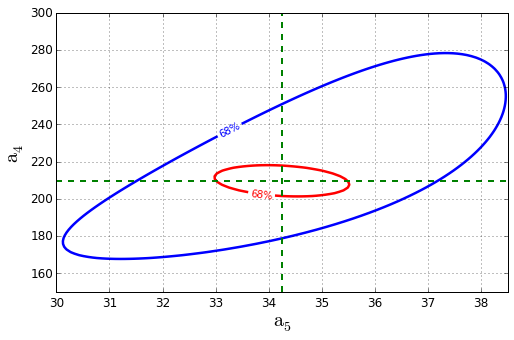

In [6]:
#Busco las curvas de covarianza
N = 100
a4 = np.linspace(150, 300, N)
a5 = np.linspace(30, 38.5, N)

X1 = []
X2 = []
for i in a4:
    for j in a5:
        r, ier = opt.leastsq(lambda p:  err([p[0], p[1], p[2], i, j]), 
                             x0 = (10, 130, 900))
        X1.append(S(θ[0:3].tolist() + [i, j]) - S(θ))
        X2.append(S(r.tolist() + [i, j]) - S(θ))
X1 = np.reshape(np.array(X1), (N,N))
X2 = np.reshape(np.array(X2), (N,N))

#Ahora voy a graficar el CL 95%, que corresponde a la curva de nivel = 2
plt.figure(3)
plt.grid()
plt.ylabel(r"$\mathrm{a}_4$")
plt.xlabel(r"$\mathrm{a}_5$")
#Nuevamente, agrego dos líneas, que corresponde a a4, a5 por cuadrados minimos
plt.axhline(θ[3], ls = "--", lw = 2, c = "g")
plt.axvline(θ[4], ls = "--", lw = 2, c = "g")
cs = plt.contour(a5, a4, X1, levels = (2.3,), colors = ["r"]);
cs1 = plt.contour(a5, a4, X2, levels = (2.3,), colors = ["b"]);
clabels = {2.3 : "68%", 6 : "95%"}
plt.clabel(cs, fmt = clabels)
plt.clabel(cs1, fmt = clabels);

La curva roja corresponde a evaluar en la función $S(\theta) - S_{\text{min}}$ con $\theta = (\hat{a}_1, \hat{a}_2, \hat{a}_3, a_4, a_5)$, mientras la segunda es evaluar la función en $\theta = (\hat{a}'_1, \hat{a}'_2, \hat{a}'_3, a_4, a_5)$, donde se minimizó la función $S(\theta)$ para cada par $(a_4, a_5)$. 
Se considera que la región de confianza más adecuada es la curva azul, ya que al minimizar los parámetros se logra desprenderse de la correlación entre parámetros.

Por lo tanto, a continuación se grafica las curvas de $68\%$ y $95\%$, con los intervalos de confianza. Estos corresponden a una estimación, ya que se debería efectuar el mismo proceso anterior (minimizar la función objetivo cada valor de $a_i$, obteniendo los demás parámetros), pero en vez de eso se considera el rectangulo donde se inscribe cada región de confianza

68%CL
I(a4) = [30.12, 38.46]
I(a5) = [167.67, 278.35]

95%CL
I(a4) = [27.62, 41.12]
I(a5) = [148.73, 349.32]



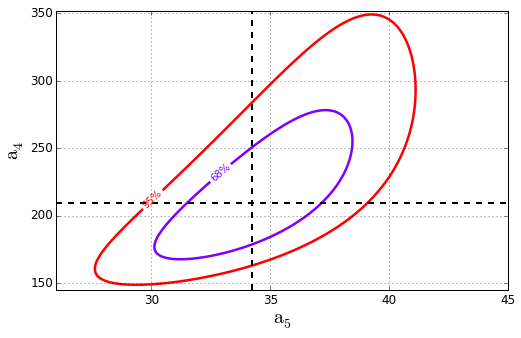

In [7]:
#Busco las curvas de covarianza
N = 100
a4 = np.linspace(145, 352, N)
a5 = np.linspace(26, 45, N)

X = []
for i in a4:
    for j in a5:
        r, ier = opt.leastsq(lambda p:  err([p[0], p[1], p[2], i, j]), 
                             x0 = (10, 130, 900))
        X.append(S(r.tolist() + [i, j]) - S(θ))
X = np.reshape(np.array(X), (N,N))


#Ahora voy a graficar el CL 95%, que corresponde a la curva de nivel = 2
plt.figure(3)
plt.grid(which="both")
plt.ylabel(r"$\mathrm{a}_4$")
plt.xlabel(r"$\mathrm{a}_5$")
#Nuevamente, agrego dos líneas, que corresponde a a4, a5 por cuadrados minimos
plt.axhline(θ[3], ls = "--", lw = 2, c = "k")
plt.axvline(θ[4], ls = "--", lw = 2, c = "k")
plt.set_cmap("rainbow")
cs = plt.contour(a5, a4, X, levels = (2.3,6));
clabels = {2.3 : "68%", 6 : "95%"}
CL = ["68%","95%"]
plt.clabel(cs, fmt = clabels)
#Imprimo los intervalos de confianza, a partir de la variable cs
#que contiene los contornos graficados en plt.contour
for i, c in enumerate(cs.allsegs):
    print("{}CL".format(CL[i]))
    print("I(a4) = [{:.2f}, {:.2f}]".format(c[0][:,0].min(), c[0][:,0].max()))
    print("I(a5) = [{:.2f}, {:.2f}]\n".format(c[0][:,1].min(), c[0][:,1].max()))